# LinkedIn Job Postings

## ADS 508 Impacting the Business with a Distributed Data Science Pipeline

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
from pyathena import connect
import awswrangler as wr
from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

## Data Ingestion

### CSV to S3

In [2]:
# Setup boto3 session parameters
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

# Establish connection
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [3]:
# Set S3 Source Location (Public bucket)
s3_public_path = "s3://linkedin-postings"

In [4]:
%store s3_public_path

Stored 's3_public_path' (str)


In [5]:
# Set S3 Destination Location (Private bucket)
s3_private_path = "s3://{}/linkedin_data".format(bucket)
print(s3_private_path)

s3://sagemaker-us-east-1-937572952481/linkedin_data


In [6]:
%store s3_private_path

Stored 's3_private_path' (str)


In [7]:
# Copy data from Public S3 bucket to Private S3 bucket
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "postings/postings.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "salaries/salaries.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "job_skills/job_skills.csv"

copy: s3://linkedin-postings/postings/postings.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/postings/postings.csv
copy: s3://linkedin-postings/salaries/salaries.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/salaries/salaries.csv
copy: s3://linkedin-postings/job_skills/job_skills.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/job_skills/job_skills.csv


In [8]:
# Check files are copied successfully to private bucket
!aws s3 ls $s3_private_path/

                           PRE job_skills/
                           PRE postings/
                           PRE salaries/


### Create Athena Database 

In [9]:
ingest_create_athena_db_passed = False

In [10]:
ingest_create_athena_table_passed = False

In [11]:
database_name = "linkedin_data"

In [12]:
# Set S3 staging directory - a temporary directory for Athena queries
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

In [13]:
# Connect to staging directory
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [14]:
# Create Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

""


### Verify database has been created

In [15]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,linkedin_data


In [16]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena Tables from CSV Files

In [17]:
table_name = 'postings'
postings_path = "s3://{}/linkedin_data/postings/".format(bucket)

drop_statement = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name)

print(drop_statement)
pd.read_sql(drop_statement, conn)
print("Attempted to Drop {} table".format(table_name))

DROP TABLE IF EXISTS linkedin_data.postings;
Attempted to Drop postings table


In [18]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        company_name string,
        title string,
        description string,
        max_salary float,
        pay_period string,
        location string,
        company_id float,
        views float,
        med_salary float,
        min_salary float,
        formatted_work_type string,
        applies float,
        original_listed_time float,
        remote_allowed float,
        job_posting_url string,
        application_url string,
        application_type string,
        expiry float,
        closed_time float,
        formatted_experience_level string,
        skills_desc string,
        listed_time string,
        posting_domain string,
        sponsored int,
        work_type string,
        currency string,
        compensation_type string,
        normalized_salary float,
        zip_code int,
        fips int
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, postings_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created postings table")

Created postings table


In [19]:
table_name_2 = "salaries"
salaries_path = "s3://{}/linkedin_data/salaries/".format(bucket)

drop_statement2 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_2)

print(drop_statement2)
pd.read_sql(drop_statement2, conn)
print("Attempted to Drop {} table".format(table_name_2))

DROP TABLE IF EXISTS linkedin_data.salaries;
Attempted to Drop salaries table


In [20]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        salary_id int,
        job_id string,
        max_salary float,
        med_salary float,
        min_salary float,
        pay_period string,
        currency string,
        compensation_type string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_2, salaries_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created salaries table")

Created salaries table


In [21]:
table_name_3 = "job_skills"
job_skills_path = "s3://{}/linkedin_data/job_skills/".format(bucket)

drop_statement3 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_3)

print(drop_statement3)
pd.read_sql(drop_statement3, conn)
print("Attempted to Drop {} table".format(table_name_3))

DROP TABLE IF EXISTS linkedin_data.job_skills;
Attempted to Drop job_skills table


In [22]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        skill_abr string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_3, job_skills_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created job_skills table")

Created job_skills table


### Verify tables have been created successfully

In [23]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,job_skills
1,postings
2,salaries


In [24]:
if table_name in df_show.values:
    ingest_create_athena_table_passed = True

In [35]:
# View postings table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name)

pd.read_sql(statement, conn)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,REQUIREMENTS2+ years sales experienceCustomer ...,detail-oriented,personable,reliable,None,70000.0,YEARLY,None,None,74447920.0,...,,Associate,,None,,0,FULL_TIME,None,None,65000.0
1,3901356487,Diversatek Healthcare,Medical Device Sales Representative,"""As a Territory Manager",None,endoscopy centers,and ambulatory surgery centers. Territory Man...,None,None,NaN,...,with frequent travel outside the local area a...,and stoop,kneel,None,distance vision,color vision,peripheral vision,None,None,NaN
2,3901356495,Quantum Research International,LINUX SYSTEM ADMINISTRATOR (CAOC),"""Mission:In support of the Compute Architectur...",None,Network Operation,Security Operation,None,None,NaN,...,standard maintenance/patching,and user/account administration using Ansible...,Linux+,None,etc. (90 day waiver may be provided to obtain...,Experience,& Skills :Experience with compiling,None,None,NaN
3,3901356508,Compri Consulting,Project Manager - Healthcare,"""Demonstrated experience integrating into an e...",None,70.0,HOURLY,None,None,46305.0,...,,Mid-Senior level,,None,,0,CONTRACT,None,None,140400.0
4,3901356509,Planet Pharma,Administrative Assistant I,"""3-month initial contract (possibility of exte...",None,W,Th)Pay Rate: $21.62,None,None,NaN,...,None,None,None,None,None,None,None,None,None,NaN


In [26]:
# View salaries table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name_2)

pd.read_sql(statement, conn)

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type
0,1,3884428798,NaN,20.0,NaN,HOURLY,USD,BASE_SALARY
1,2,3887470552,25.0,NaN,23.0,HOURLY,USD,BASE_SALARY
2,3,3884431523,120000.0,NaN,100000.0,YEARLY,USD,BASE_SALARY
3,4,3884911725,200000.0,NaN,10000.0,YEARLY,USD,BASE_SALARY
4,5,3887473220,35.0,NaN,33.0,HOURLY,USD,BASE_SALARY


In [27]:
# View job skills table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name_3)

pd.read_sql(statement, conn)

,job_id,skill_abr
0,3884428798,MRKT
1,3884428798,PR
2,3884428798,WRT
3,3887473071,SALE
4,3887465684,FIN


## Data Exploration

In [45]:
statement = """
    SELECT 
        job_id, company_name, title, max_salary, location,
        company_id, views, med_salary, min_salary, formatted_work_type, applies,
        formatted_experience_level, skills_desc, work_type,
        normalized_salary, zip_code
    FROM {}.{}
    LIMIT 10000;
    """.format(database_name, table_name)

# Execute query and load results into a Pandas DataFrame
postings_df = pd.read_sql(statement, conn)

In [58]:
statement = """SELECT * FROM {}.{}""".format(database_name, table_name_2)
salaries_df = pd.read_sql(statement, conn)

In [59]:
statement = """SELECT * FROM {}.{}""".format(database_name, table_name_3)
job_skills_df = pd.read_sql(statement, conn)

### postings EDA

In [46]:
# Basic stats
print(postings_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   job_id                      10000 non-null  object 
 1   company_name                3037 non-null   object 
 2   title                       2606 non-null   object 
 3   max_salary                  24 non-null     float64
 4   location                    1314 non-null   object 
 5   company_id                  94 non-null     float64
 6   views                       100 non-null    float64
 7   med_salary                  65 non-null     float64
 8   min_salary                  81 non-null     float64
 9   formatted_work_type         761 non-null    object 
 10  applies                     97 non-null     float64
 11  formatted_experience_level  512 non-null    object 
 12  skills_desc                 502 non-null    object 
 13  work_type                   476 

In [47]:
# Data types
postings_data_types = postings_df.dtypes
print(postings_data_types)

job_id                         object
company_name                   object
title                          object
max_salary                    float64
location                       object
company_id                    float64
views                         float64
med_salary                    float64
min_salary                    float64
formatted_work_type            object
applies                       float64
formatted_experience_level     object
skills_desc                    object
work_type                      object
normalized_salary             float64
zip_code                      float64
dtype: object


In [48]:
# Missing values
missing_values = postings_df.isnull().sum()
print(missing_values[missing_values > 0])

company_name                  6963
title                         7394
max_salary                    9976
location                      8686
company_id                    9906
views                         9900
med_salary                    9935
min_salary                    9919
formatted_work_type           9239
applies                       9903
formatted_experience_level    9488
skills_desc                   9498
work_type                     9524
normalized_salary             9772
zip_code                      9919
dtype: int64


In [49]:
# Duplicates
duplicates = postings_df.duplicated().sum()
print(duplicates)

5641


In [50]:
# Summary statistics for numerical columns
print(postings_df.describe())

         max_salary    company_id         views    med_salary    min_salary  \
count  2.400000e+01  9.400000e+01  1.000000e+02  6.500000e+01  8.100000e+01   
mean   2.043255e+07  2.282581e+06  2.170293e+06  7.449931e+06  3.807553e+11   
std    3.347897e+07  1.128424e+07  1.210494e+07  2.350759e+07  7.167597e+11   
min    0.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
25%    7.230025e+04  1.525000e+01  1.645000e+01  5.000000e+00  3.000000e+00   
50%    2.941220e+06  7.450000e+01  3.801000e+03  2.704900e+04  4.600000e+01   
75%    1.873832e+07  8.296700e+04  9.161875e+04  1.085000e+05  1.861042e+07   
max    1.028295e+08  7.938354e+07  9.040678e+07  9.742182e+07  1.713475e+12   

            applies  normalized_salary      zip_code  
count  9.700000e+01       2.280000e+02  8.100000e+01  
mean   7.242163e+11       2.330760e+11  1.557320e+06  
std    8.507813e+11       5.888496e+11  9.168751e+06  
min    1.000000e+00       0.000000e+00  0.000000e+00  
25%    7.0000

In [52]:
# Top 10 unique values in categorical columns
categorical = ["title", "company_name", "location", "formatted_work_type", "formatted_experience_level", "skills_desc"]
for col in categorical:
    print(postings_df[col].value_counts().head(10))

title
                                                                                                161
 religion                                                                                        36
HOURLY                                                                                           36
YEARLY                                                                                           26
 color                                                                                           20
 Inc."                                                                                           20
 Home Improvement                                                                                14
 Dental                                                                                          14
 we integrate diversity                                                                          14
 and may require climbing a ladder to store and retrieve materials or place and remove signs  

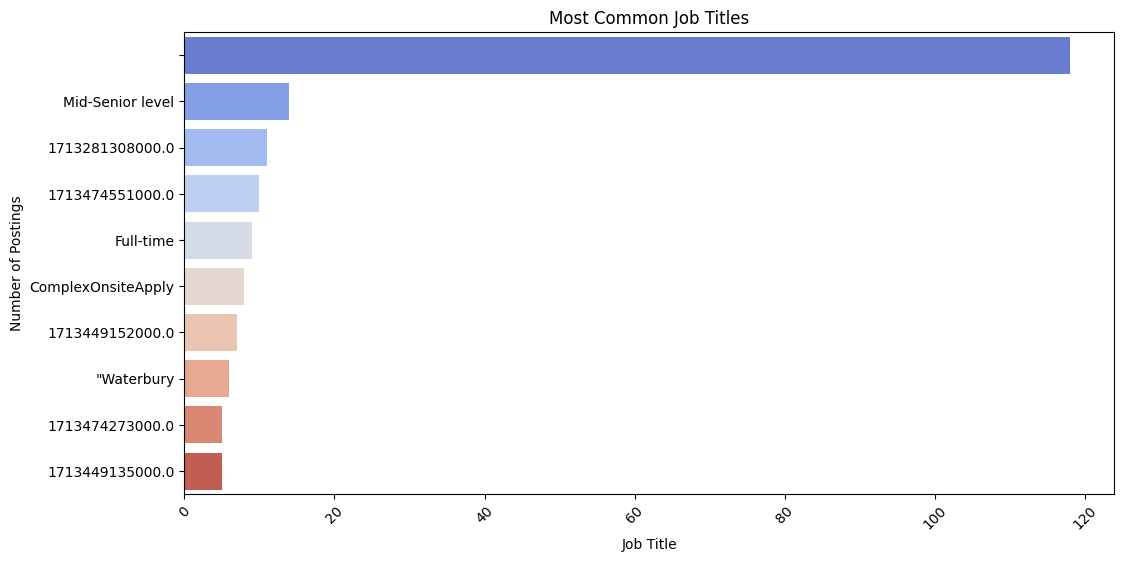

In [57]:
# Visualize most common job titles
top_titles = postings_df["formatted_experience_level"].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(y=top_titles.index, x=top_titles.values, palette="coolwarm")
plt.xlabel("Job Title")
plt.ylabel("Number of Postings")
plt.title("Most Common Job Titles")
plt.xticks(rotation=45)
plt.show()

### salaries EDA

In [60]:
# Basic stats
print(salaries_df.describe())
print(salaries_df.info())

          salary_id    max_salary     med_salary    min_salary
count  40785.000000  3.394700e+04    6838.000000  3.394700e+04
mean   20393.000000  9.620987e+04   21370.298198  6.508541e+04
std    11773.759701  6.587373e+05   51338.564169  4.650612e+05
min        1.000000  1.000000e+00       0.000000  1.000000e+00
25%    10197.000000  5.000000e+01      18.500000  3.900000e+01
50%    20393.000000  8.500000e+04      25.000000  6.230000e+04
75%    30589.000000  1.425000e+05    2207.000000  1.000000e+05
max    40785.000000  1.200000e+08  750000.000000  8.500000e+07
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40785 entries, 0 to 40784
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salary_id          40785 non-null  int64  
 1   job_id             40785 non-null  object 
 2   max_salary         33947 non-null  float64
 3   med_salary         6838 non-null   float64
 4   min_salary         33947 non-nul

In [61]:
# Data types
salaries_data_types = salaries_df.dtypes
print(salaries_data_types)

salary_id              int64
job_id                object
max_salary           float64
med_salary           float64
min_salary           float64
pay_period            object
currency              object
compensation_type     object
dtype: object


In [62]:
# Missing values
salaries_df.isnull().sum()

salary_id                0
job_id                   0
max_salary            6838
med_salary           33947
min_salary            6838
pay_period               0
currency                 0
compensation_type        0
dtype: int64

In [63]:
# Duplicates
salaries_df.duplicated().sum()

0

In [65]:
# Salary distributions
salary_columns = ["min_salary", "med_salary", "max_salary"]
print(salaries_df[salary_columns].describe())

         min_salary     med_salary    max_salary
count  3.394700e+04    6838.000000  3.394700e+04
mean   6.508541e+04   21370.298198  9.620987e+04
std    4.650612e+05   51338.564169  6.587373e+05
min    1.000000e+00       0.000000  1.000000e+00
25%    3.900000e+01      18.500000  5.000000e+01
50%    6.230000e+04      25.000000  8.500000e+04
75%    1.000000e+05    2207.000000  1.425000e+05
max    8.500000e+07  750000.000000  1.200000e+08


<Axes: xlabel='Salary Type', ylabel='Salary'>

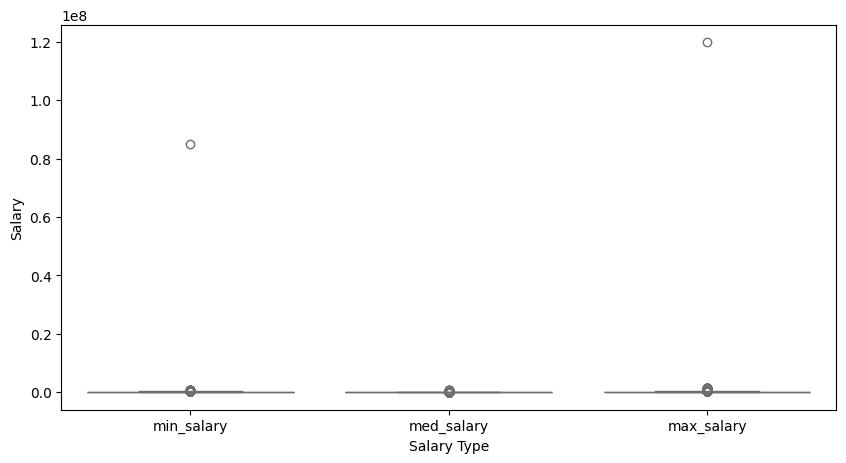

In [69]:
# Visualize salary distribution
df_melted = salaries_df.melt(value_vars=["min_salary", "med_salary", "max_salary"], 
                     var_name="Salary Type", value_name="Salary")

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_melted, x="Salary Type", y="Salary", palette="coolwarm")

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(salaries_df["min_salary"], color="blue", kde=True, label="Min Salary", bins=30)
sns.histplot(salaries_df["med_salary"], color="green", kde=True, label="Median Salary", bins=30)
sns.histplot(salaries_df["max_salary"], color="red", kde=True, label="Max Salary", bins=30)

# Customize plot
plt.title("Salary Distribution (Histogram)")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### job_skills EDA

In [71]:
# Basic stats
print(job_skills_df.describe())
print(job_skills_df.info())

            job_id skill_abr
count       213768    213768
unique      126807        35
top     3888474981        IT
freq             3     26137
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213768 entries, 0 to 213767
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   job_id     213768 non-null  object
 1   skill_abr  213768 non-null  object
dtypes: object(2)
memory usage: 3.3+ MB
None


In [72]:
# Data types
job_skills_data_types = job_skills_df.dtypes
print(job_skills_data_types)

job_id       object
skill_abr    object
dtype: object


In [73]:
# Missing values
job_skills_df.isnull().sum()

job_id       0
skill_abr    0
dtype: int64

In [74]:
# Duplicates
job_skills_df.duplicated().sum()

0

In [75]:
# Summary statistics
print(f"Unique Job Skills: {job_skills_df['skill_abr'].nunique()}")

Unique Job Skills: 35


In [76]:
# Skill frequencies
job_skills_df["skill_abr"] = job_skills_df["skill_abr"].astype(str)  # Ensure it's a string
skills = job_skills_df["skill_abr"].str.split(",").explode().str.strip().value_counts()
print(skills.head(20))

skill_abr
IT      26137
SALE    22475
MGMT    20861
MNFC    18185
HCPR    17369
BD      14290
ENG     13009
OTHR    12608
FIN      8540
MRKT     5525
ACCT     5461
ADM      4860
CUST     4292
PRJM     3997
ANLS     3858
RSCH     2986
HR       2647
LGL      2371
CNSL     2338
EDU      2290
Name: count, dtype: int64


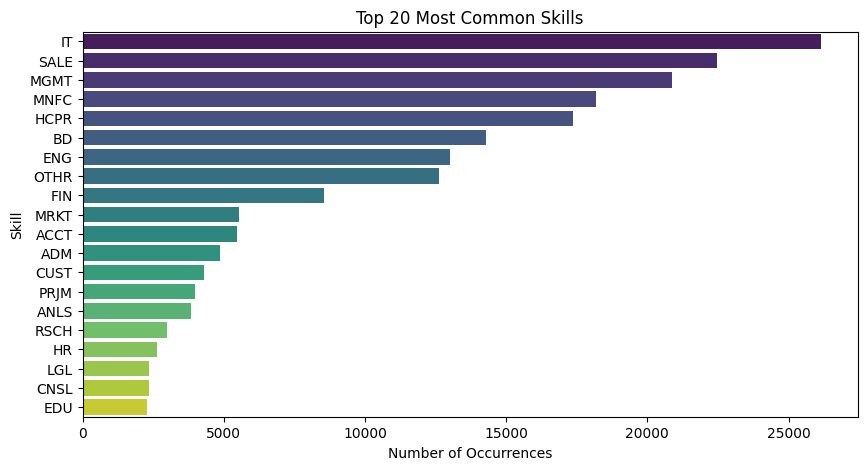

In [79]:
# Concatenate all skills descriptions
all_skills = " ".join(job_skills_df["skill_abr"].dropna())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_skills)

# Bar Chart of Top 20 Most Common Skills
top_skills = skills.head(20)

plt.figure(figsize=(10, 5))
sns.barplot(y=top_skills.index, x=top_skills.values, palette="viridis")
plt.title("Top 20 Most Common Skills")
plt.xlabel("Number of Occurrences")
plt.ylabel("Skill")
plt.show()

### Bias Analysis

In [ ]:
# Salary Bias 
plt.figure(figsize=(12, 6))
sns.boxplot(data=postings_df, x="formatted_experience_level", y="normalized_salary", palette="coolwarm")
plt.title("Salary Distribution by Experience Level")
plt.xlabel("Experience Level")
plt.ylabel("Normalized Salary")
plt.xticks(rotation=45)
plt.show()